In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install shap
!pip install torch==1.9.1
!pip install torchvision==0.10.1

ERROR: Could not find a version that satisfies the requirement torch==1.9.1 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0)
ERROR: No matching distribution found for torch==1.9.1
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.1 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0)
ERROR: No matching distribution found for torchvision==0.10.1


In [8]:
import zipfile
# Ruta del archivo ZIP que deseas descomprimir en Google Drive
ruta_zip = '/content/drive/MyDrive/HOJAS/Hojas-20240131T050046Z-001.zip'  # Cambia esta ruta por la de tu archivo ZIP

# Ruta de la carpeta donde deseas extraer los archivos
ruta_destino = '/content/descomprimido/'  # Cambia esta ruta según tus preferencias

# Descomprimir el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
    archivo_zip.extractall(ruta_destino)

In [9]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Configuración del dispositivo para usar CUDA si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición de transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Actualizado para ResNet-50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para cargar datos
def load_data(train_directory, test_directory):
    datasets = {
        "train": ImageFolder(root=train_directory, transform=transform),
        "test": ImageFolder(root=test_directory, transform=transform)
    }
    dataloaders = {
        x: DataLoader(datasets[x], batch_size=32, shuffle=True) for x in ['train', 'test']
    }
    return dataloaders

# Cargar y preparar el modelo ResNet50
def prepare_model(num_classes):
    weights = ResNet50_Weights.IMAGENET1K_V1
    model = resnet50(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Entrenamiento del modelo
def train_and_evaluate_model(model, dataloaders, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Listas para guardar los valores de pérdida y precisión
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = total = 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(dataloaders['train']))
        train_accuracies.append(100 * correct / total)

        # Evaluación
        model.eval()
        test_loss = 0.0
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(dataloaders['test']))
        test_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, '
              f'Train Accuracy: {train_accuracies[-1]:.2f}%, Test Accuracy: {test_accuracies[-1]:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies

# Directorios de entrenamiento y validación (actualiza estas rutas según tu configuración)
train_directory = '/content/descomprimido/Hojas/Train'
test_directory = '/content/descomprimido/Hojas/Test'

# Cargar datos de entrenamiento y validación
dataloaders = load_data(train_directory, test_directory)

# Definir el número de clases
num_classes = 3  # Ajusta esto según tu conjunto de datos específico

# Preparar y entrenar el modelo
model = prepare_model(num_classes)
#train_and_evaluate_model(model, dataloaders, epochs=5)


Epoch 1/20, Train Loss: 0.2358, Test Loss: 1.3021, Train Accuracy: 92.54%, Test Accuracy: 83.05%
Epoch 2/20, Train Loss: 0.0978, Test Loss: 0.0292, Train Accuracy: 97.45%, Test Accuracy: 98.55%
Epoch 3/20, Train Loss: 0.0663, Test Loss: 0.0198, Train Accuracy: 98.30%, Test Accuracy: 99.27%
Epoch 4/20, Train Loss: 0.0952, Test Loss: 0.0111, Train Accuracy: 97.76%, Test Accuracy: 99.76%
Epoch 5/20, Train Loss: 0.0247, Test Loss: 0.0079, Train Accuracy: 99.39%, Test Accuracy: 100.00%
Epoch 6/20, Train Loss: 0.0286, Test Loss: 0.0123, Train Accuracy: 99.09%, Test Accuracy: 99.76%
Epoch 7/20, Train Loss: 0.0099, Test Loss: 0.0063, Train Accuracy: 99.76%, Test Accuracy: 100.00%
Epoch 8/20, Train Loss: 0.0468, Test Loss: 0.0250, Train Accuracy: 98.42%, Test Accuracy: 99.03%
Epoch 9/20, Train Loss: 0.0507, Test Loss: 0.0238, Train Accuracy: 98.48%, Test Accuracy: 98.79%
Epoch 10/20, Train Loss: 0.0196, Test Loss: 0.0187, Train Accuracy: 99.45%, Test Accuracy: 98.79%
Epoch 11/20, Train Loss: 0.

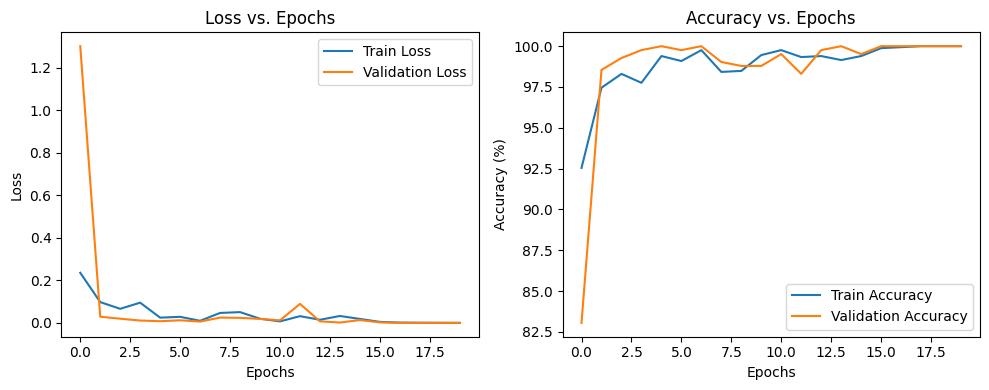

In [10]:
import matplotlib.pyplot as plt

# Ejecutar entrenamiento y evaluación
train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate_model(model, dataloaders, epochs=20)

# Graficar pérdidas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Graficar precisión
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()